In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import zipfile
import seaborn as sns
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

# set seed to reproduce similar results
np.random.seed(0)

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


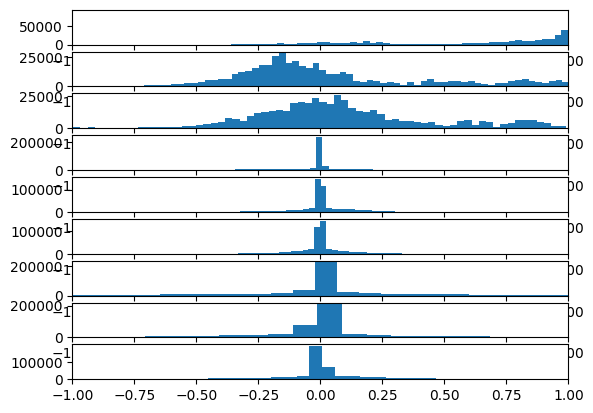

In [5]:
# plot distributions
plot_distributions(trainX)

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)
93/93 [==============================] - 2s 6ms/step
**** Confusion Matrix ****
[[471   3  22   0   0   0]
 [  0 446  25   0   0   0]
 [  1   0 419   0   0   0]
 [  0   2   4 435  49   1]
 [  1   0   0 144 387   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       1.00      0.95      0.97       496
  WALKING_UPSTAIRS       0.99      0.95      0.97       471
WALKING_DOWNSTAIRS       0.89      1.00      0.94       420
           SITTING       0.75      0.89      0.81       491
          STANDING       0.89      0.73      0.80       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.91      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.91      0.91      2947



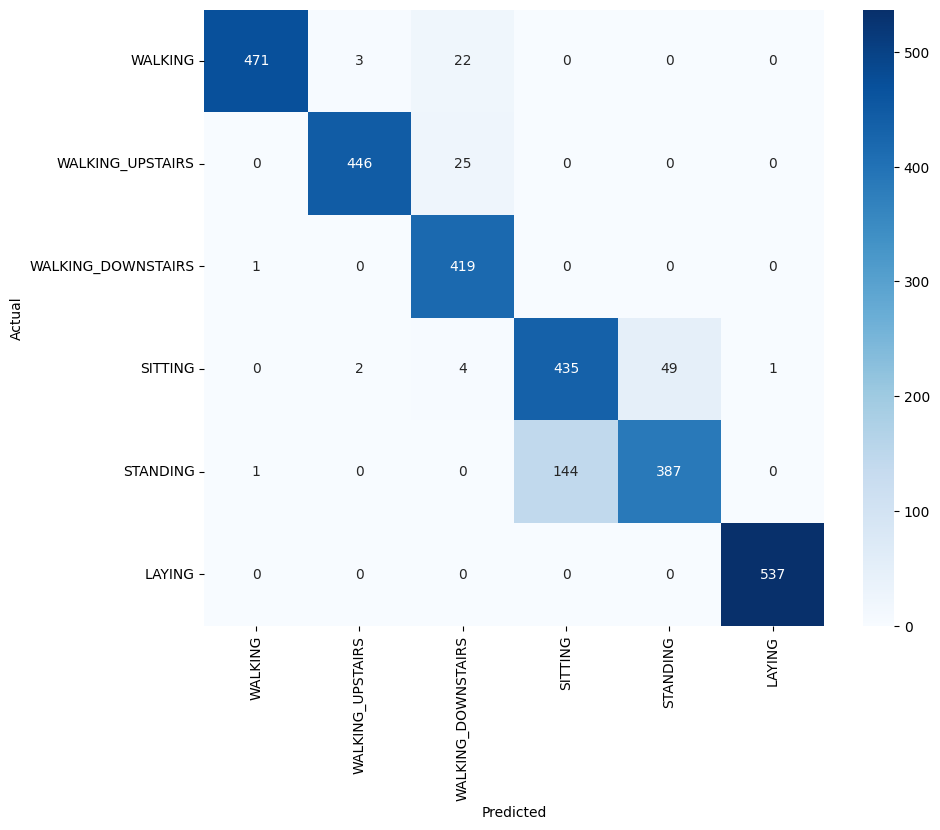

>#1: 91.449
93/93 [==============================] - 2s 5ms/step
**** Confusion Matrix ****
[[471   5  20   0   0   0]
 [  4 443  24   0   0   0]
 [  3   1 416   0   0   0]
 [  2  23   0 426  38   2]
 [  2   0   0 125 405   0]
 [  0  26   0   0   0 511]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.98      0.95      0.96       496
  WALKING_UPSTAIRS       0.89      0.94      0.91       471
WALKING_DOWNSTAIRS       0.90      0.99      0.95       420
           SITTING       0.77      0.87      0.82       491
          STANDING       0.91      0.76      0.83       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



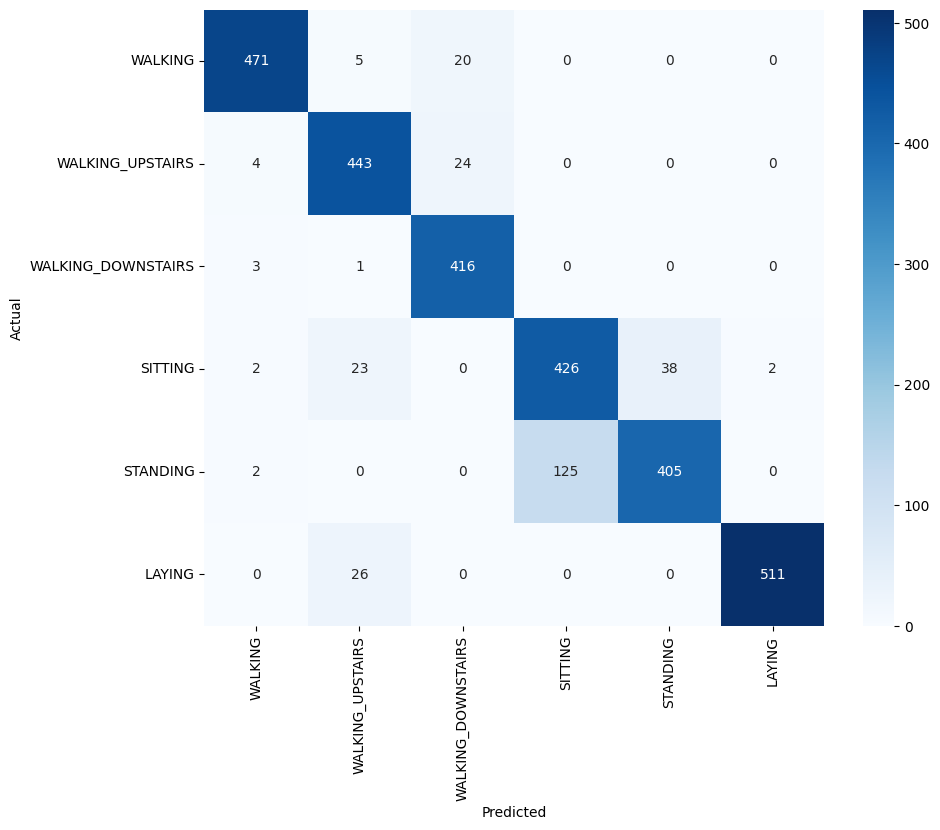

>#2: 90.668
93/93 [==============================] - 2s 7ms/step
**** Confusion Matrix ****
[[490   0   2   0   4   0]
 [ 13 382  27   0  49   0]
 [ 14   1 403   0   2   0]
 [  1   7   0 410  71   2]
 [  0   0   0 104 428   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.95      0.99      0.97       496
  WALKING_UPSTAIRS       0.92      0.81      0.86       471
WALKING_DOWNSTAIRS       0.93      0.96      0.95       420
           SITTING       0.80      0.84      0.82       491
          STANDING       0.77      0.80      0.79       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



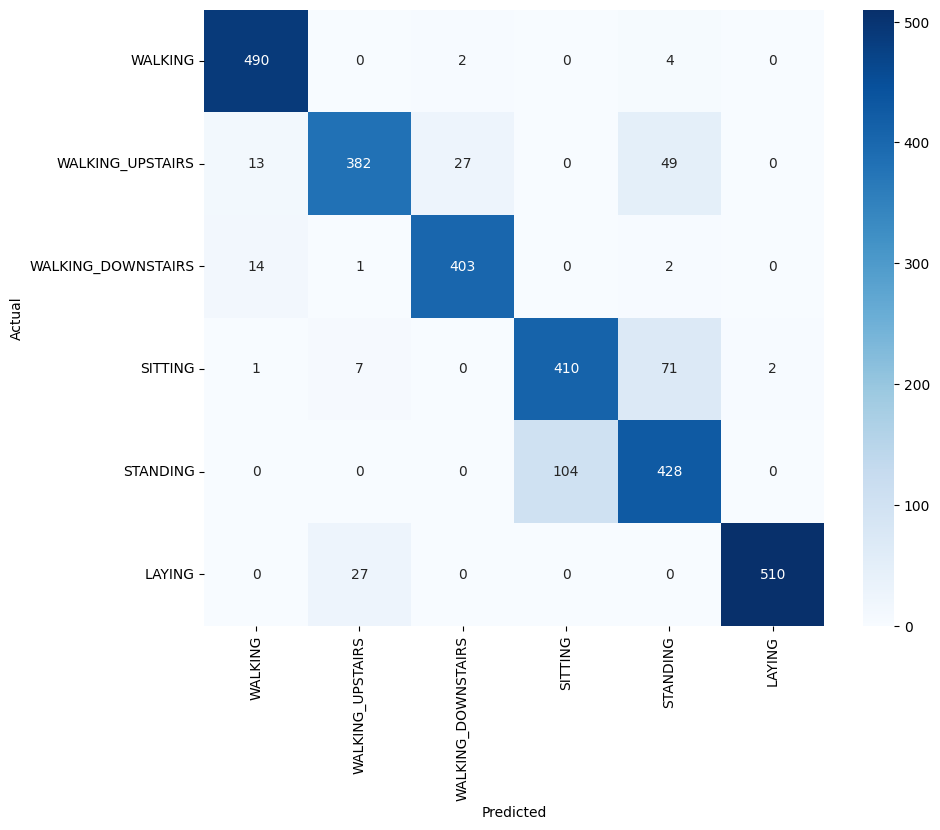

>#3: 89.006
93/93 [==============================] - 2s 7ms/step
**** Confusion Matrix ****
[[464   2  30   0   0   0]
 [  2 445  24   0   0   0]
 [  0   5 415   0   0   0]
 [  0  11   0 407  73   0]
 [  0   0   0 131 401   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       1.00      0.94      0.96       496
  WALKING_UPSTAIRS       0.91      0.94      0.93       471
WALKING_DOWNSTAIRS       0.88      0.99      0.93       420
           SITTING       0.76      0.83      0.79       491
          STANDING       0.85      0.75      0.80       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



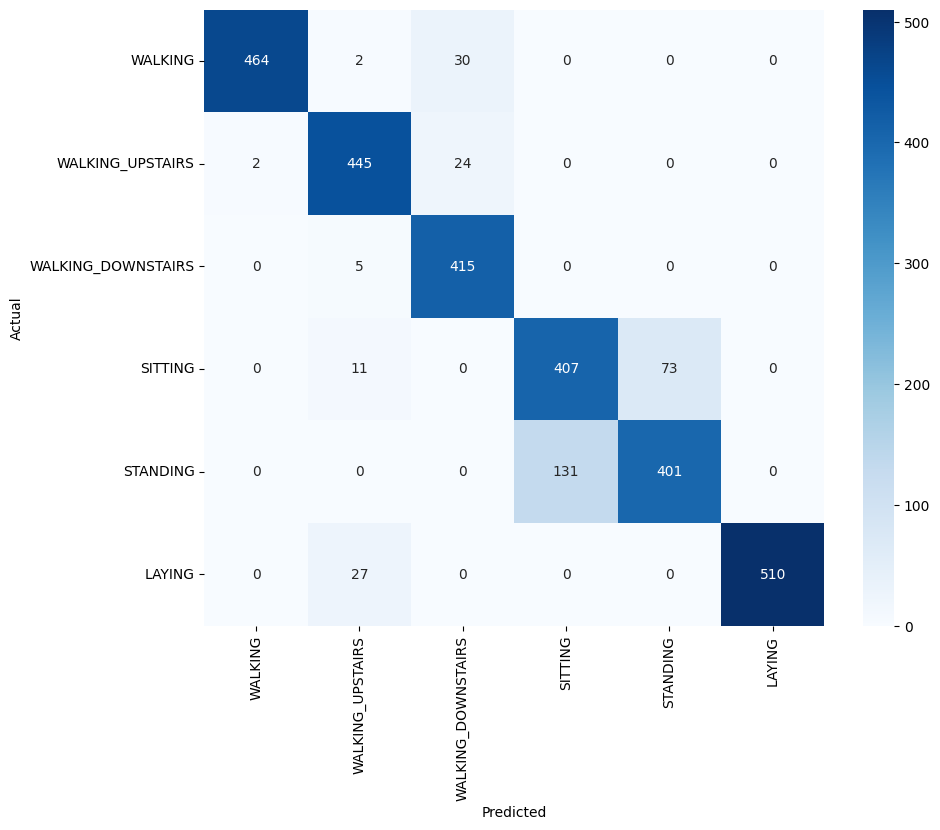

>#4: 89.650
93/93 [==============================] - 2s 5ms/step
**** Confusion Matrix ****
[[439   1  56   0   0   0]
 [  1 438  32   0   0   0]
 [  0   0 420   0   0   0]
 [  0   8   0 385  98   0]
 [  0   0   0  53 479   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       1.00      0.89      0.94       496
  WALKING_UPSTAIRS       0.92      0.93      0.93       471
WALKING_DOWNSTAIRS       0.83      1.00      0.91       420
           SITTING       0.88      0.78      0.83       491
          STANDING       0.83      0.90      0.86       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



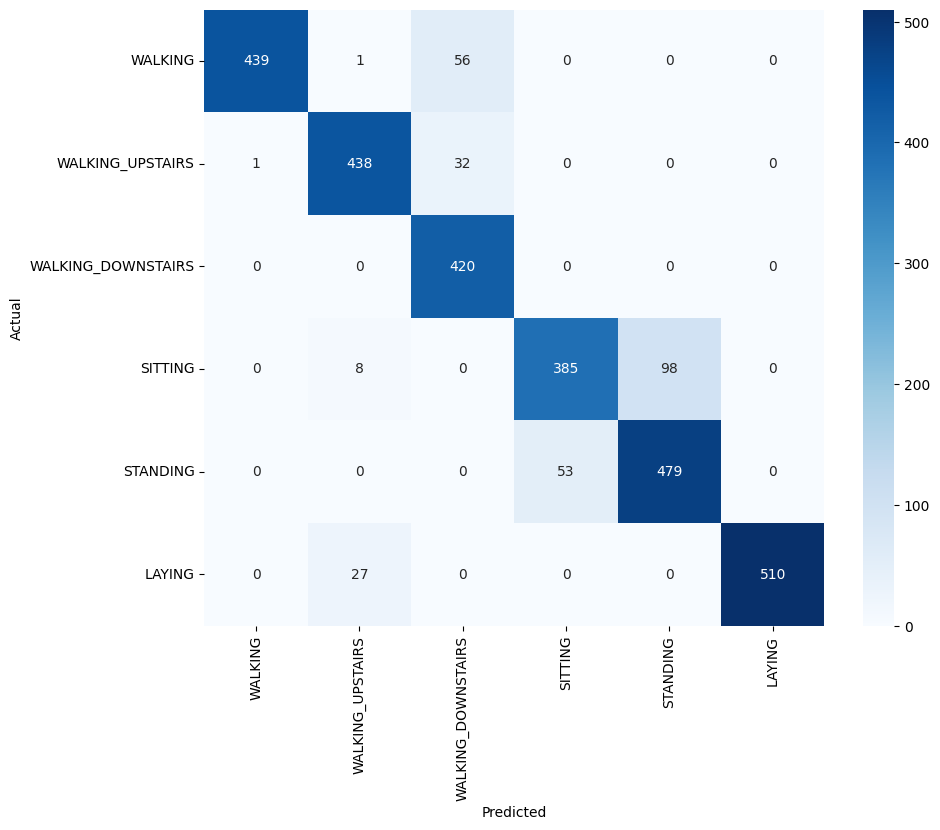

>#5: 90.635
93/93 [==============================] - 2s 9ms/step
**** Confusion Matrix ****
[[480   0  16   0   0   0]
 [  8 438  25   0   0   0]
 [  9   2 409   0   0   0]
 [  1   7   0 424  59   0]
 [  0   0   0 115 417   0]
 [  0   1   0   0  26 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.96      0.97      0.97       496
  WALKING_UPSTAIRS       0.98      0.93      0.95       471
WALKING_DOWNSTAIRS       0.91      0.97      0.94       420
           SITTING       0.79      0.86      0.82       491
          STANDING       0.83      0.78      0.81       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



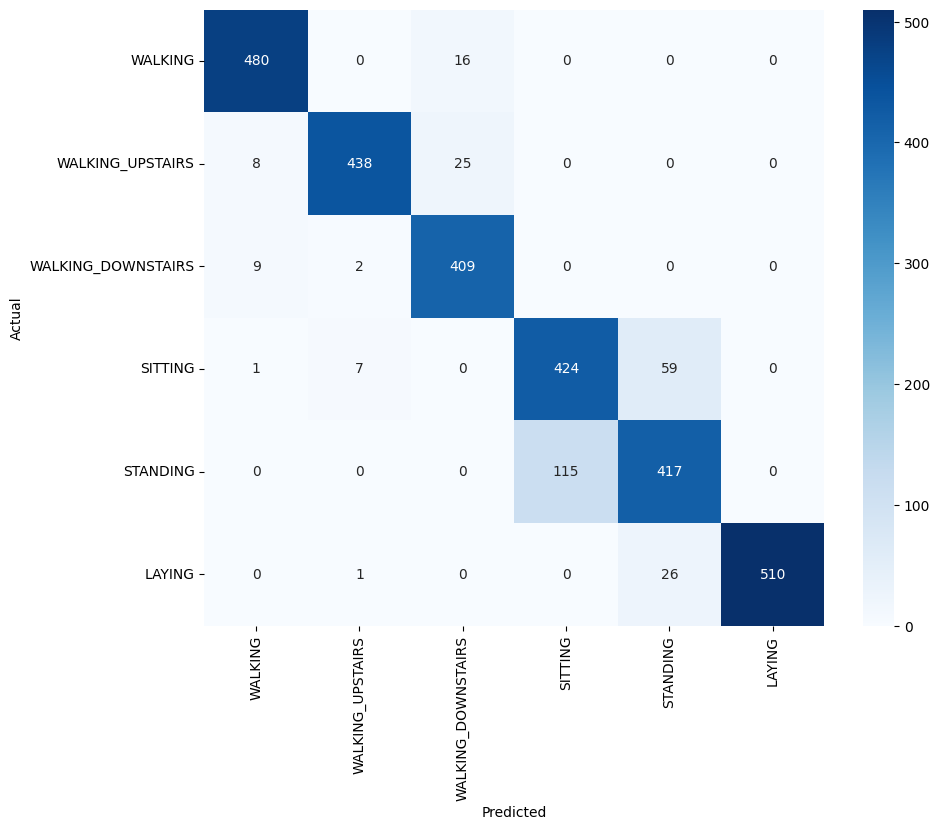

>#6: 90.872
93/93 [==============================] - 2s 7ms/step
**** Confusion Matrix ****
[[468   2  26   0   0   0]
 [  0 447  24   0   0   0]
 [  8   4 408   0   0   0]
 [  1   9   0 403  78   0]
 [  1   0   0  89 442   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.98      0.94      0.96       496
  WALKING_UPSTAIRS       0.91      0.95      0.93       471
WALKING_DOWNSTAIRS       0.89      0.97      0.93       420
           SITTING       0.82      0.82      0.82       491
          STANDING       0.85      0.83      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



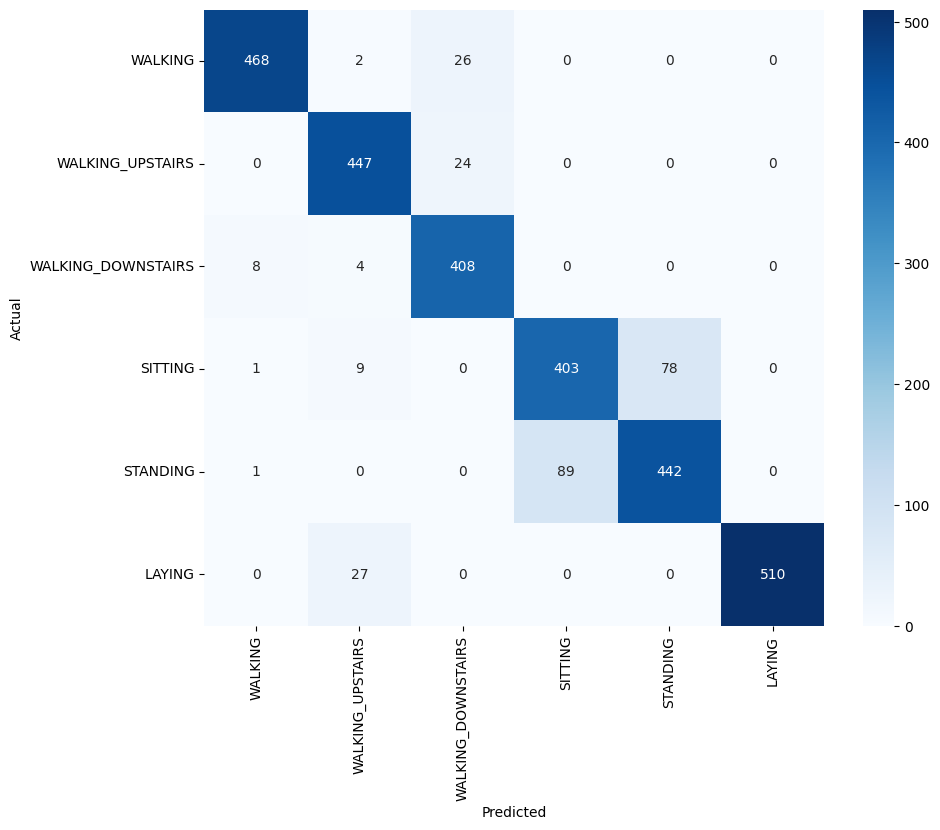

>#7: 90.872
93/93 [==============================] - 3s 8ms/step
**** Confusion Matrix ****
[[491   1   3   0   1   0]
 [ 21 439  11   0   0   0]
 [ 18   5 397   0   0   0]
 [  0   2   0 408  76   5]
 [  0   0   0  74 458   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.93      0.99      0.96       496
  WALKING_UPSTAIRS       0.98      0.93      0.96       471
WALKING_DOWNSTAIRS       0.97      0.95      0.96       420
           SITTING       0.85      0.83      0.84       491
          STANDING       0.86      0.86      0.86       532
            LAYING       0.99      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



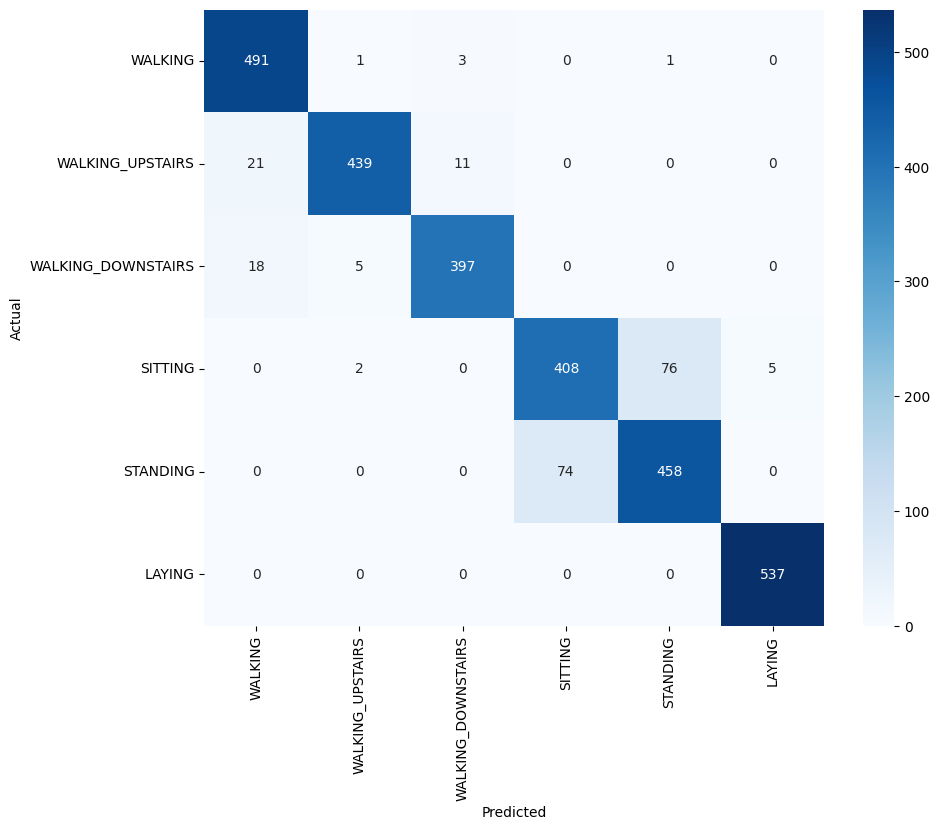

>#8: 92.637
93/93 [==============================] - 2s 8ms/step
**** Confusion Matrix ****
[[493   0   3   0   0   0]
 [  2 445  24   0   0   0]
 [  3   5 412   0   0   0]
 [  0   7   0 418  66   0]
 [  0   0   0 124 408   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.99      0.99      0.99       496
  WALKING_UPSTAIRS       0.92      0.94      0.93       471
WALKING_DOWNSTAIRS       0.94      0.98      0.96       420
           SITTING       0.77      0.85      0.81       491
          STANDING       0.86      0.77      0.81       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



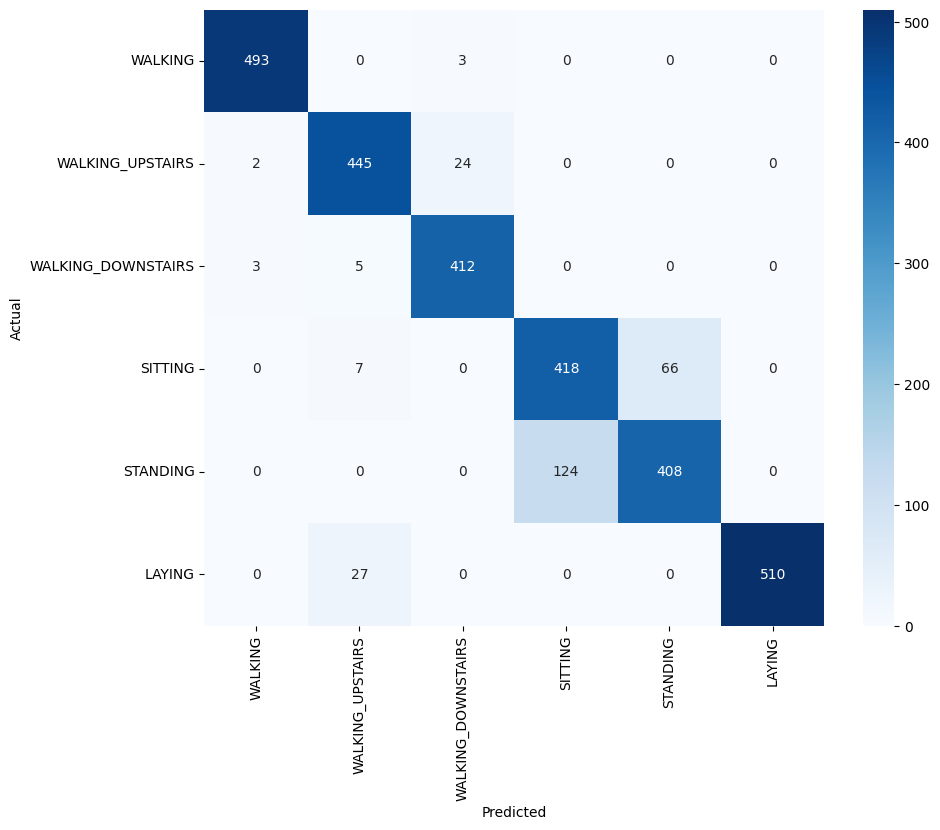

>#9: 91.144
93/93 [==============================] - 2s 6ms/step
**** Confusion Matrix ****
[[467   7  22   0   0   0]
 [  1 445  25   0   0   0]
 [  1   1 418   0   0   0]
 [  0  24   0 405  62   0]
 [  0   1   0  73 458   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       1.00      0.94      0.97       496
  WALKING_UPSTAIRS       0.88      0.94      0.91       471
WALKING_DOWNSTAIRS       0.90      1.00      0.94       420
           SITTING       0.85      0.82      0.84       491
          STANDING       0.88      0.86      0.87       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



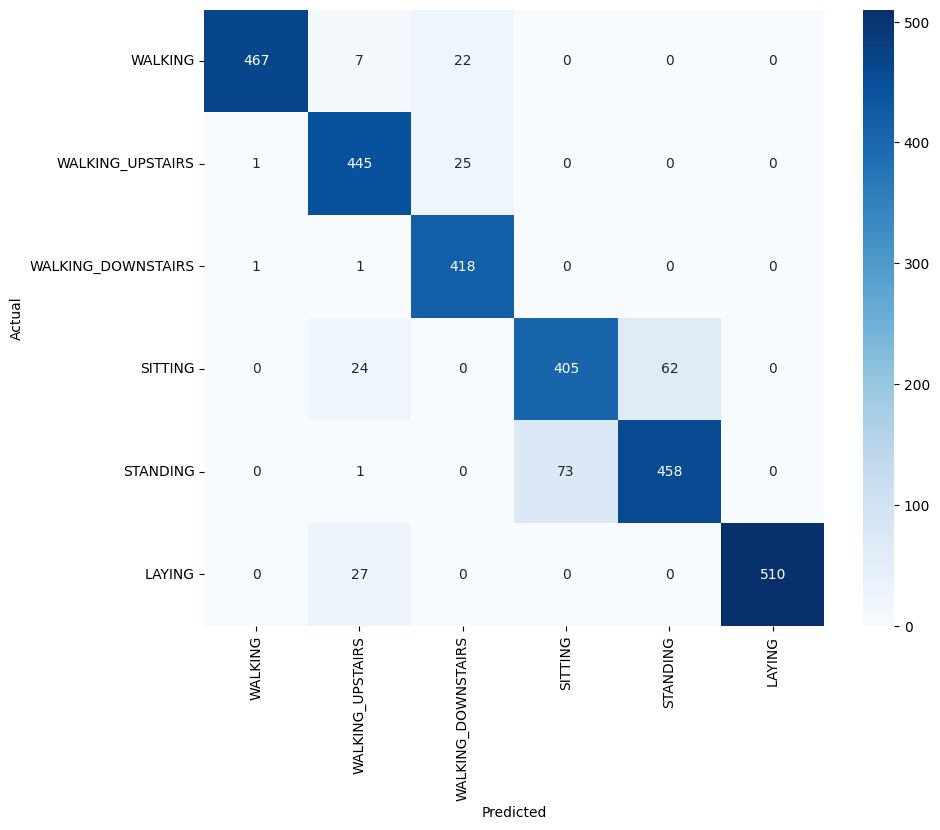

>#10: 91.720
[91.44893288612366, 90.66847562789917, 89.00576829910278, 89.65049386024475, 90.63454270362854, 90.87207317352295, 90.87207317352295, 92.63657927513123, 91.14353656768799, 91.7203962802887]
Accuracy: 90.865% (+/-0.965)


In [7]:
def display_results(testy,predictions):
    classNames=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    predictions = model.predict(testX)
    display_results(testy, predictions)
    return accuracy
 
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 
# run the experiment
run_experiment()